# Analyse Noise Complaints in NYC

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import time
from datetime import datetime, timedelta
import seaborn as sns
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from prettytable import PrettyTable
import geoplotlib
from geoplotlib.utils import BoundingBox
from geoplotlib.colors import ColorMap
from geoplotlib.layers import BaseLayer
from geoplotlib.core import BatchPainter
from geoplotlib.colors import create_set_cmap
import matplotlib.pyplot as plt
%matplotlib inline

## Load the filtered dataset

In [2]:
# Load it into a Dataframe using pandas
path = '../data/311_cleaned.csv'
df = pd.read_csv(path)
df.head()

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Created Date             Closed Date Agency  \
0  02/17/2011 08:56:08 PM  02/17/2011 10:06:39 PM   NYPD   
1  07/12/2010 02:56:00 PM  07/13/2010 12:00:00 PM   DSNY   
2  07/12/2010 04:28:00 PM  07/14/2010 12:00:00 PM   DSNY   
3  07/12/2010 06:04:00 PM  07/12/2010 06:04:00 PM   DSNY   
4  07/12/2010 06:36:00 PM  07/15/2010 12:00:00 PM   DSNY   

         Complaint Type               Descriptor               Location Type  \
0   Noise - Residential         Banging/Pounding  Residential Building/House   
1      Dirty Conditions  E11 Litter Surveillance                    Sidewalk   
2      Dirty Conditions               E4 18" Law                      Street   
3     Derelict Vehicles     14 Derelict Vehicles                      Street   
4  Sanitation Condition                 22 Weeds                    Sidewalk   

            City    Borough Latitude  Longitude  
0  EAST ELMHURST     QUEENS  40.7554 -73.896723  
1       BROOKLYN   BROOKLYN  40.5903 -73.942885  
2       NEW YORK  MANHATTAN  40.8366 -73.941224  
3        BAYSIDE     QUEENS  40.7597 -73.774048  
4   FAR ROCKAWAY     QUEENS  40.6006 -73.760412

## Data manging on the filtered dataset

> Create functions

In [3]:
# Create a function that gets the year of a datetime string
def getYear(s):
    first_split = s.split(' ')[0]
    return int(first_split.split('/')[-1])

In [4]:
# Create function that calculates the time diff in minutes between created and closed date
def getCallDuration(created, closed):
    # Assign format and type
    time_format = "%m/%d/%Y %I:%M:%S %p"
    created_date = datetime.strptime(created, time_format)
    closed_date = datetime.strptime(closed, time_format)
    
    # Convert to unix timestamp
    created_date = time.mktime(created_date.timetuple())
    closed_date = time.mktime(closed_date.timetuple())
    
    # they are now in seconds, subtract and then divide by 60 to get minutes.
    return int(closed_date-created_date) / 60

In [5]:
# Create a function that gets the hour in 24 hour format
def getHour24(s):
    # Set date formats
    initial_format = "%m/%d/%Y %I:%M:%S %p"
    second_format = "%m/%d/%Y %H:%M:%S"
    # Convert from str to datetime
    first_step = datetime.strptime(s,initial_format)
    # And then back to str
    second_step = datetime.strftime(first_step,second_format)
    # Keep only the time
    third_step = second_step.split(' ')[1]
    # Return the hour of time
    return int(third_step.split(':')[0])

> Filter the data using the functions

In [6]:
# Now create a new column named year and store the values of the above function
df['Created Year']= df['Created Date'].apply(lambda x: getYear(x))
df['Closed Year']= df['Closed Date'].apply(lambda x: getYear(x))

In [7]:
# Keep only 2010 to 2017 data
df = df[df['Closed Year'].isin(range(2010,2018))]

In [8]:
# Remove useless lines
df = df[df['Borough']!='Unspecified']

In [9]:
# Now create a new column named Call Duration and store the values of the above function
df['Call Duration']= df[['Created Date','Closed Date']].apply(lambda x: getCallDuration(*x), axis=1)

In [10]:
# Drop rows in which call duration is negative. It doesn't make sense (~3000 lines)
df = df[df['Call Duration'] >= 0]

In [11]:
# Now create a new column named Created hour and apply the function getHour24
df['Created Hour'] = df['Created Date'].apply(lambda x: getHour24(x))

In [12]:
# Convert City variable to uppercase in order to match duplicates
df['City'] = df['City'].apply(lambda x: x.upper())

In [13]:
df.head()

Created Date             Closed Date Agency  \
0  02/17/2011 08:56:08 PM  02/17/2011 10:06:39 PM   NYPD   
1  07/12/2010 02:56:00 PM  07/13/2010 12:00:00 PM   DSNY   
2  07/12/2010 04:28:00 PM  07/14/2010 12:00:00 PM   DSNY   
3  07/12/2010 06:04:00 PM  07/12/2010 06:04:00 PM   DSNY   
4  07/12/2010 06:36:00 PM  07/15/2010 12:00:00 PM   DSNY   

         Complaint Type               Descriptor               Location Type  \
0   Noise - Residential         Banging/Pounding  Residential Building/House   
1      Dirty Conditions  E11 Litter Surveillance                    Sidewalk   
2      Dirty Conditions               E4 18" Law                      Street   
3     Derelict Vehicles     14 Derelict Vehicles                      Street   
4  Sanitation Condition                 22 Weeds                    Sidewalk   

            City    Borough Latitude  Longitude  Created Year  Closed Year  \
0  EAST ELMHURST     QUEENS  40.7554 -73.896723          2011         2011   
1       BROOKLYN   BROOKLYN  40.5903 -73.942885          2010         2010   
2       NEW YORK  MANHATTAN  40.8366 -73.941224          2010         2010   
3        BAYSIDE     QUEENS  40.7597 -73.774048          2010         2010   
4   FAR ROCKAWAY     QUEENS  40.6006 -73.760412          2010         2010   

   Call Duration  Created Hour  
0             70            20  
1           1264            14  
2           2612            16  
3              0            18  
4           3924            18

> Save the data into a new CSV to release memory

In [14]:
# Create a new csv
df.to_csv('../data/311_cleaned_2.csv', index=False)

## Filter noise related data

> Load the new filtered data

In [2]:
# Load it into a Dataframe using pandas
path = '../data/311_cleaned_2.csv'
df = pd.read_csv(path)
df.head()

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Created Date             Closed Date Agency  \
0  02/17/2011 08:56:08 PM  02/17/2011 10:06:39 PM   NYPD   
1  07/12/2010 02:56:00 PM  07/13/2010 12:00:00 PM   DSNY   
2  07/12/2010 04:28:00 PM  07/14/2010 12:00:00 PM   DSNY   
3  07/12/2010 06:04:00 PM  07/12/2010 06:04:00 PM   DSNY   
4  07/12/2010 06:36:00 PM  07/15/2010 12:00:00 PM   DSNY   

         Complaint Type               Descriptor               Location Type  \
0   Noise - Residential         Banging/Pounding  Residential Building/House   
1      Dirty Conditions  E11 Litter Surveillance                    Sidewalk   
2      Dirty Conditions               E4 18" Law                      Street   
3     Derelict Vehicles     14 Derelict Vehicles                      Street   
4  Sanitation Condition                 22 Weeds                    Sidewalk   

            City    Borough Latitude  Longitude  Created Year  Closed Year  \
0  EAST ELMHURST     QUEENS  40.7554 -73.896723          2011         2011   
1       BROOKLYN   BROOKLYN  40.5903 -73.942885          2010         2010   
2       NEW YORK  MANHATTAN  40.8366 -73.941224          2010         2010   
3        BAYSIDE     QUEENS  40.7597 -73.774048          2010         2010   
4   FAR ROCKAWAY     QUEENS  40.6006 -73.760412          2010         2010   

   Call Duration  Created Hour  
0             70            20  
1           1264            14  
2           2612            16  
3              0            18  
4           3924            18

In [3]:
# Keep noise related data in a seperate dataframe
df_noise = df[df['Complaint Type'].str.contains("Noise")]

In [4]:
# Unique noise types
df_noise['Complaint Type'].unique()

array(['Noise - Residential', 'Noise - Street/Sidewalk',
       'Noise - Commercial', 'Noise - Park', 'Noise - House of Worship',
       'Noise - Vehicle', 'Noise - Helicopter', 'Collection Truck Noise',
       'Noise Survey'], dtype=object)

In [5]:
# Create a frequency table in order to plot
noise_freq = df_noise['Complaint Type'].groupby(df_noise['Complaint Type']).count().sort_values(ascending=1).reset_index(name='count')
noise_freq

Complaint Type    count
0    Collection Truck Noise      274
1        Noise - Helicopter     3772
2  Noise - House of Worship     7443
3              Noise Survey    16022
4              Noise - Park    22205
5           Noise - Vehicle   115853
6        Noise - Commercial   229477
7   Noise - Street/Sidewalk   236406
8       Noise - Residential  1188740

We should better keep the noise related complain types with the highest frequency as the rest will not make any difference in the end. Thus,

In [6]:
# Save the five most significant noise incidents in a list
noise_list = list(noise_freq['Complaint Type'].values)[-5:]
noise_list

['Noise - Park',
 'Noise - Vehicle',
 'Noise - Commercial',
 'Noise - Street/Sidewalk',
 'Noise - Residential']

In [7]:
# Re-filter the data
df_noise = df_noise[df_noise['Complaint Type'].isin(noise_list)]

In [8]:
# Check unique values
df_noise['Complaint Type'].unique()

array(['Noise - Residential', 'Noise - Street/Sidewalk',
       'Noise - Commercial', 'Noise - Park', 'Noise - Vehicle'], dtype=object)

Now we are sure that the correct noise complaints are filtered. We will then create a YEAR column to check noise complains per year in a barplot and check the trend.

In [9]:
# List the noise complains per year
noise_freq_time = df_noise.groupby('Created Year')['Created Year'].count().reset_index(name='count').sort_values(by='Created Year', ascending=1)
noise_freq_time

Created Year   count
0          2010  170272
1          2011  161783
2          2012  179333
3          2013  217383
4          2014  283499
5          2015  323922
6          2016  357387
7          2017   99102

## Plot noise complains over time

Let's check the above table in a barplot

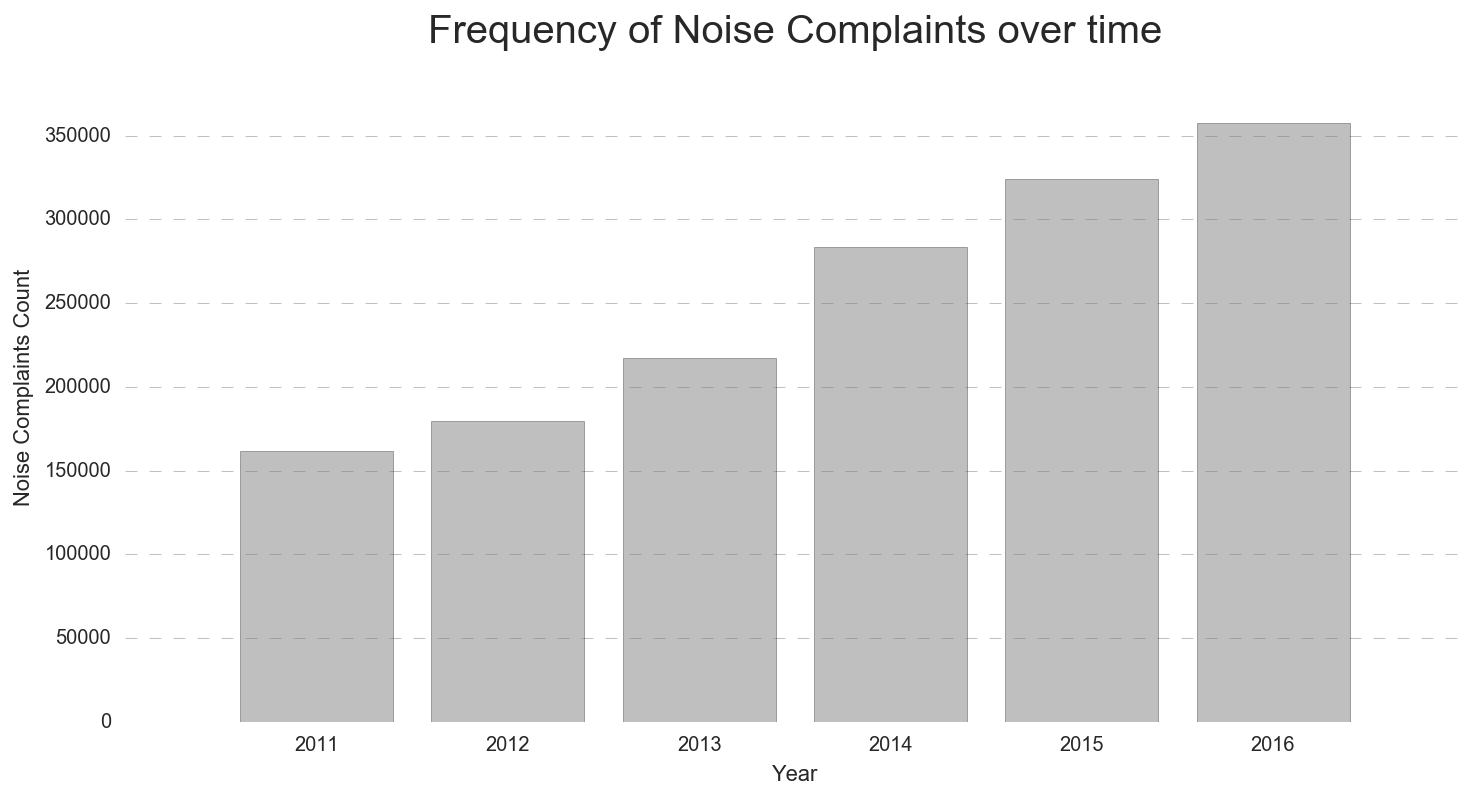

In [12]:
# Use full resolution of retina display
%config InlineBackend.figure_format = 'retina'

# Drop 2017 and 2010 as it could be misleading as only few values for the first two months exist
noise_freq_time = noise_freq_time[(noise_freq_time['Created Year'] != 2017) & (noise_freq_time['Created Year'] != 2010)]

# use seaborn to set our graphing style. The style 'white' creates a white background for our graph
sns.set_style("white") 

# Assign x and y axes
x = noise_freq_time['Created Year']
y = noise_freq_time['count']

# Give indeces to complaints
x_pos = np.arange(len(x))

# Assign the size of the plot before declaring the plot
plt.figure(figsize=(12, 6))

# Create a series of grey dashed lines across the each
# labled y-value of the graph
plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)

# Give the x and y values to the barplot
plt.bar(x_pos, y, align='center', color='grey', alpha=.5)

# Match the indeces with the correct call category and assign them to the x-axis
plt.yticks(np.arange(0, round(max(y),-5), 50000))
plt.xticks(x_pos, x)

# get rid of borders for our graph using seaborn's despine function
sns.despine(top=1, right=1, left=1, bottom=1)

# Give labels and titles
plt.ylabel("Noise Complaints Count")
plt.xlabel("Year")
plt.title("Frequency of Noise Complaints over time",fontsize=20)

# Show the barplot
plt.show()

It is obvious that there was a constant raise in noise complains since 2011 until 2016. Let's create the same **barplot but this time split by noise complain category** and see all 5 category barplots.

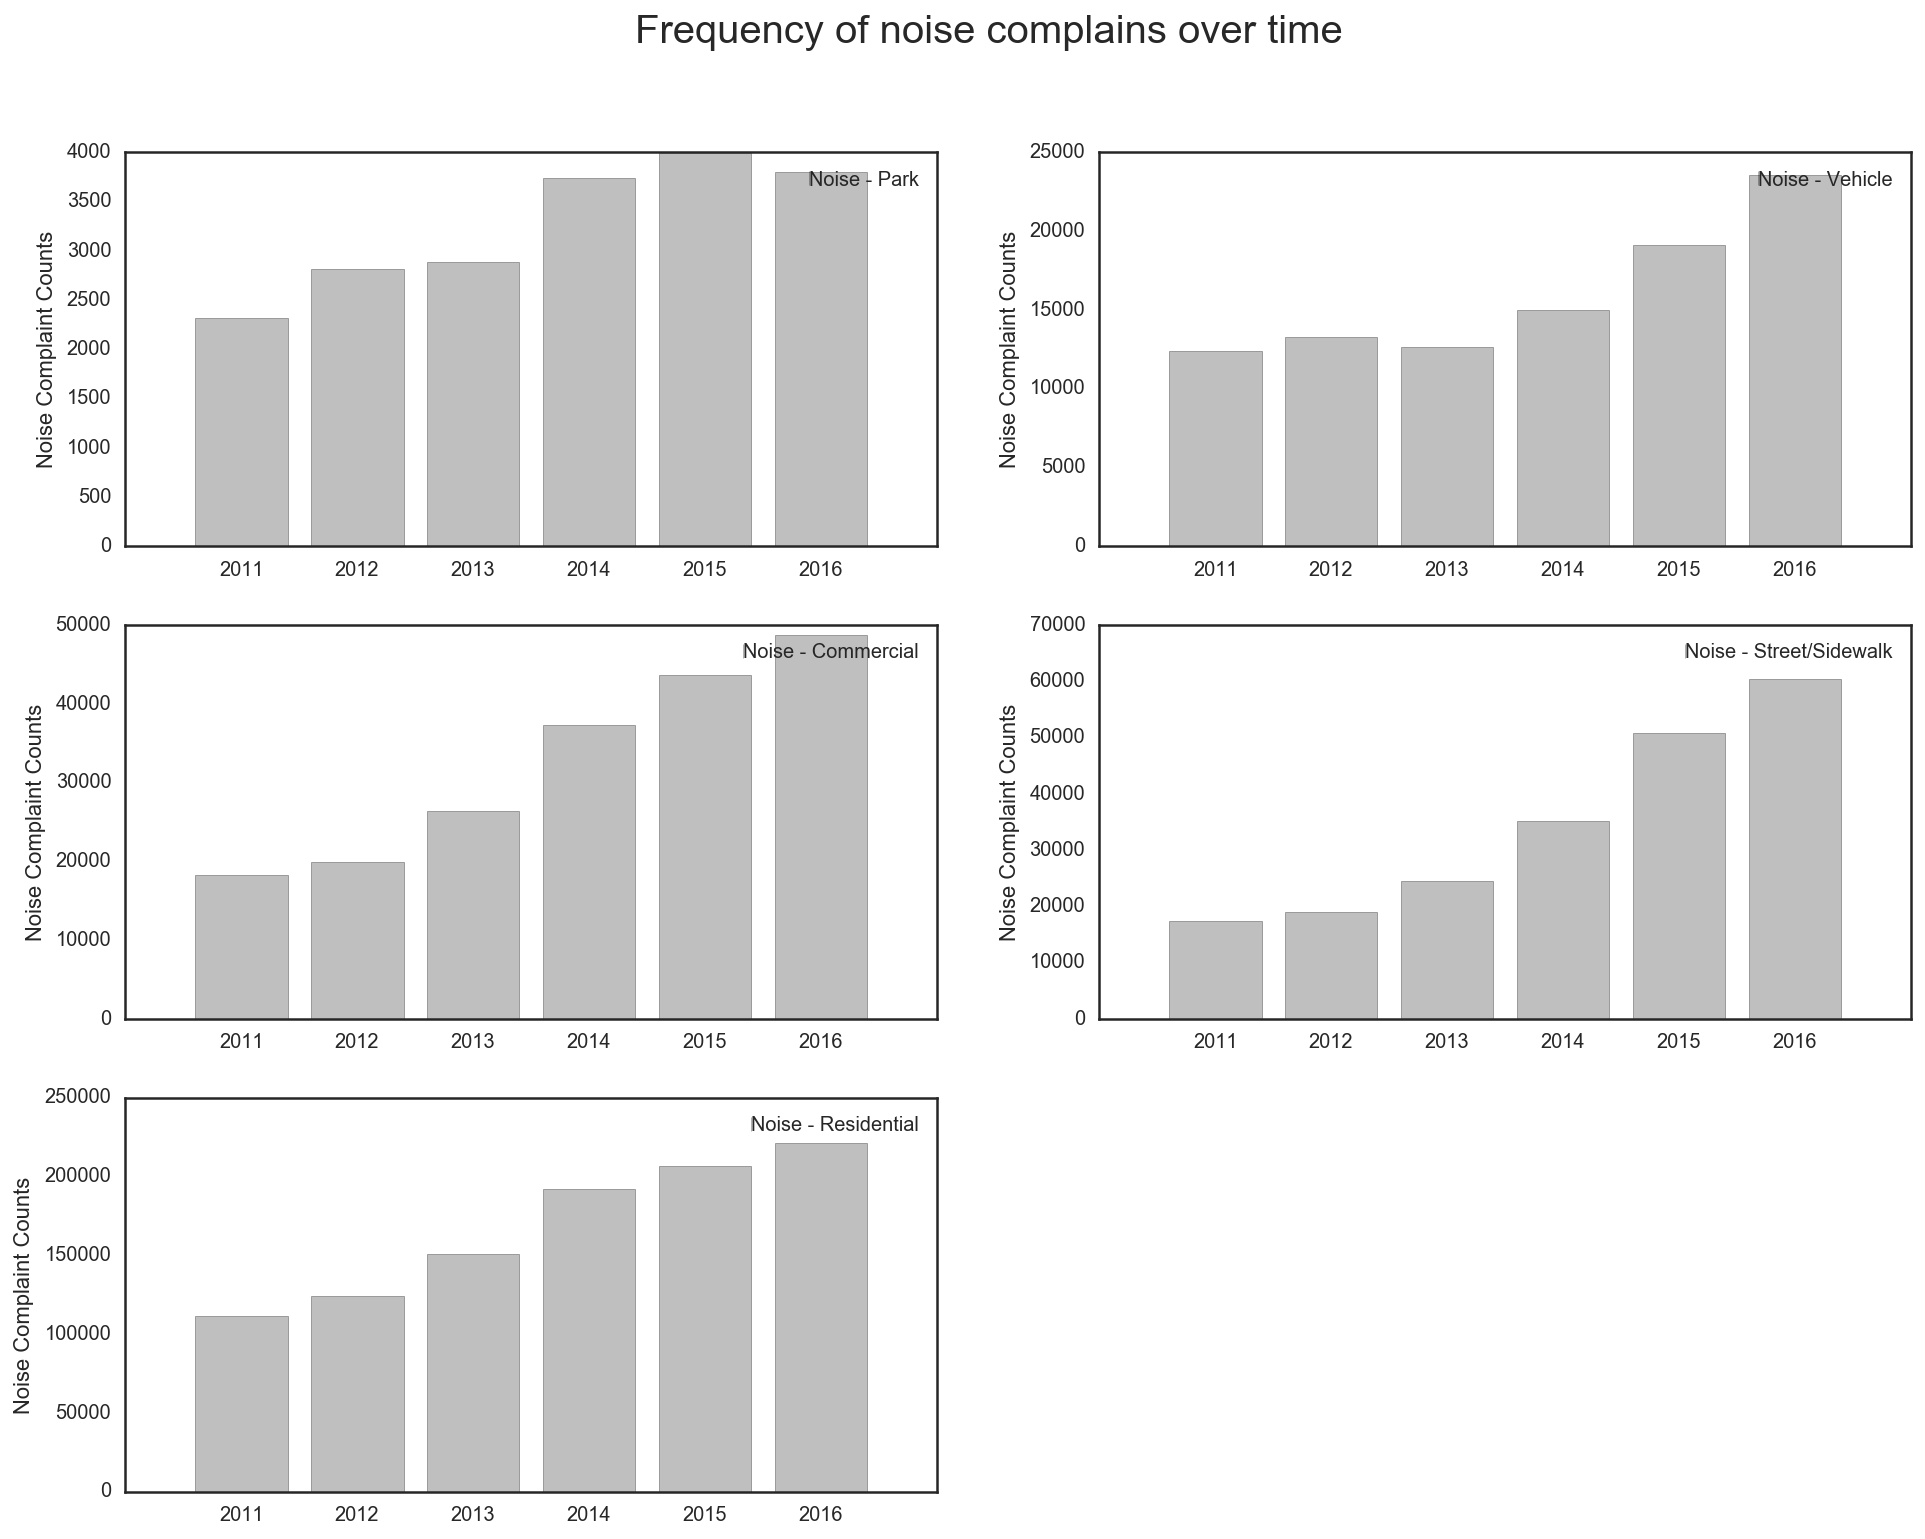

In [13]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(16, 12))
plt.suptitle('Frequency of noise complains over time',fontsize=20)
for index, complain in enumerate(noise_list):
    # Create a matrix of subplots with 3 rows and two columns
    plt.subplot(3, 2, index + 1)

    # Create a sub-df for each category
    temp_df = df_noise[df_noise['Complaint Type'] == complain]

    # Drop 2017 and 2010 as it could be misleading as only few values for the first two
    # months exist
    temp_df = temp_df[(temp_df['Created Year'] != 2017) & (temp_df['Created Year'] != 2010)]

    # Count frequency of complaint occurence
    occurence = temp_df.groupby('Created Year')['Created Year'].count().reset_index(
        name='count').sort_values(by='Created Year', ascending=1)

    # Assign x and y values
    x = occurence['Created Year']
    y = occurence['count']

    # Give indeces to complaints
    x_pos = np.arange(len(x))
    
    plt.bar(x_pos, y, align='center', alpha=.5, color='grey', label=complain)
    plt.xticks(x_pos, x)
    plt.ylabel("Noise Complaint Counts")
    plt.legend(loc='upper right', frameon=False,
               handlelength=0, handletextpad=0)

# Show the barplot
plt.show()

Let's examine the **hours** with the highest noise complains in NYC.

In [14]:
# List the number of noise complaints per hour
noise_freq_hour = df_noise.groupby('Created Hour')['Created Hour'].count().reset_index(
    name='count').sort_values(by='Created Hour', ascending=1)
noise_freq_hour

Created Hour   count
0              0  187928
1              1  146826
2              2   95361
3              3   60101
4              4   41191
5              5   26611
6              6   20135
7              7   20067
8              8   22477
9              9   25542
10            10   28569
11            11   31158
12            12   34502
13            13   37511
14            14   40437
15            15   43997
16            16   48882
17            17   56768
18            18   68205
19            19   83621
20            20  107334
21            21  139546
22            22  197157
23            23  228755

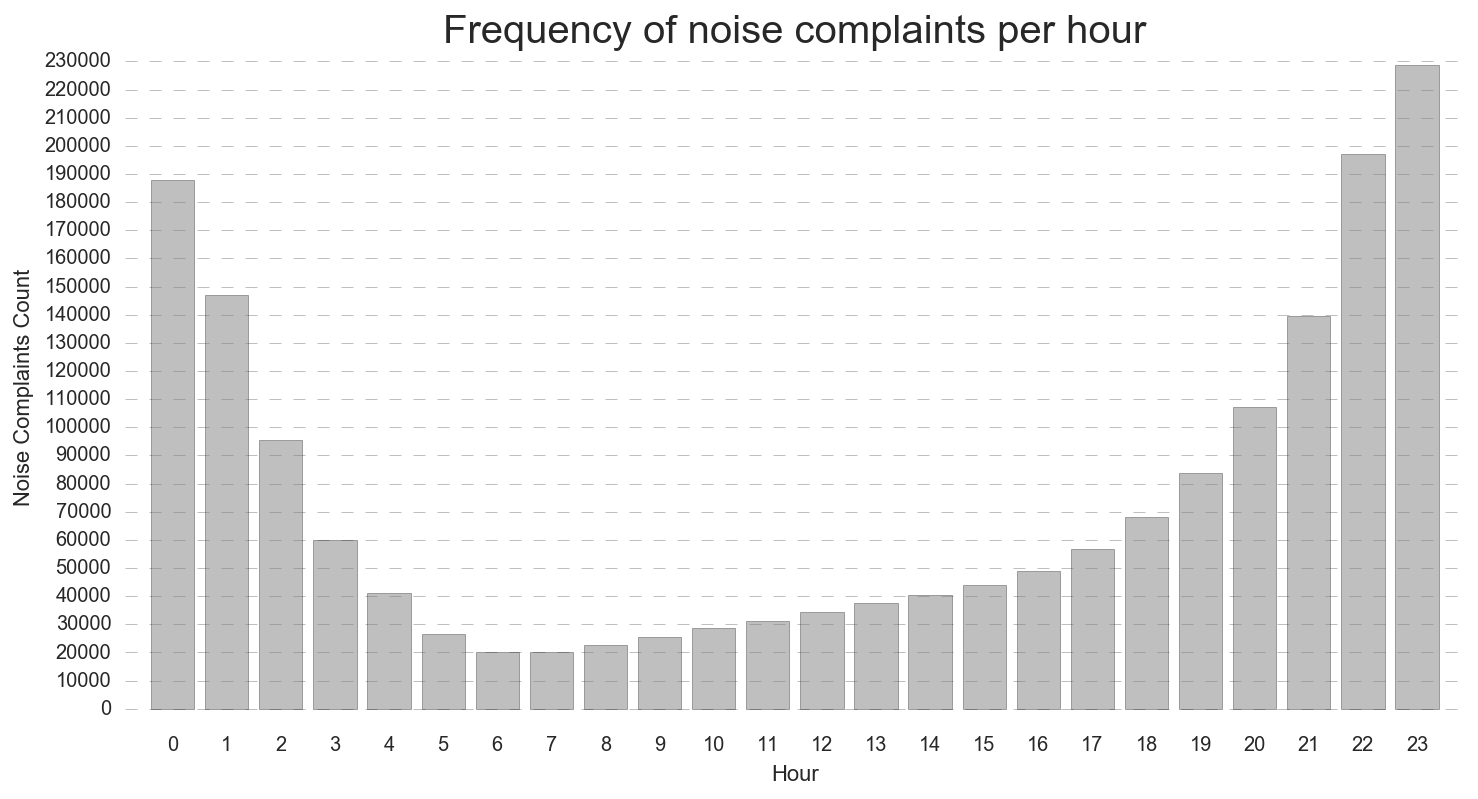

In [16]:
# Use full resolution of retina display
%config InlineBackend.figure_format = 'retina'

# use seaborn to set our graphing style. The style 'white' creates a white background for our graph
sns.set_style("white") 

# Assign x and y values
x = noise_freq_hour['Created Hour']
y = noise_freq_hour['count']

# Assign the size of the plot before declaring the plot
plt.figure(figsize=(12, 6))

# Create a series of grey dashed lines across the each
# labled y-value of the graph
plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)

# Give the x and y values to the barplot
plt.bar(x, y, align='center', color='grey', alpha=.5)

# Create ticks
plt.xticks(range(0, 24, 1))
plt.yticks(np.arange(round(min(y),-5), round(max(y),-5)+50000, 10000))
plt.margins(0.02)

# get rid of borders for our graph using seaborn's despine function
sns.despine(top=1, right=1, left=1, bottom=1)

# Give labels and titles
plt.ylabel("Noise Complaints Count")
plt.xlabel("Hour")
plt.title("Frequency of noise complaints per hour",fontsize=20)

# Show the barplot
plt.show()

We see that people are bothered by noise usually during sleeping hours. **Since 20 at night to 02** in the morning is the time span with the most complaints. Last step is to **split the same plot per noise complaint type** as we did before for years.

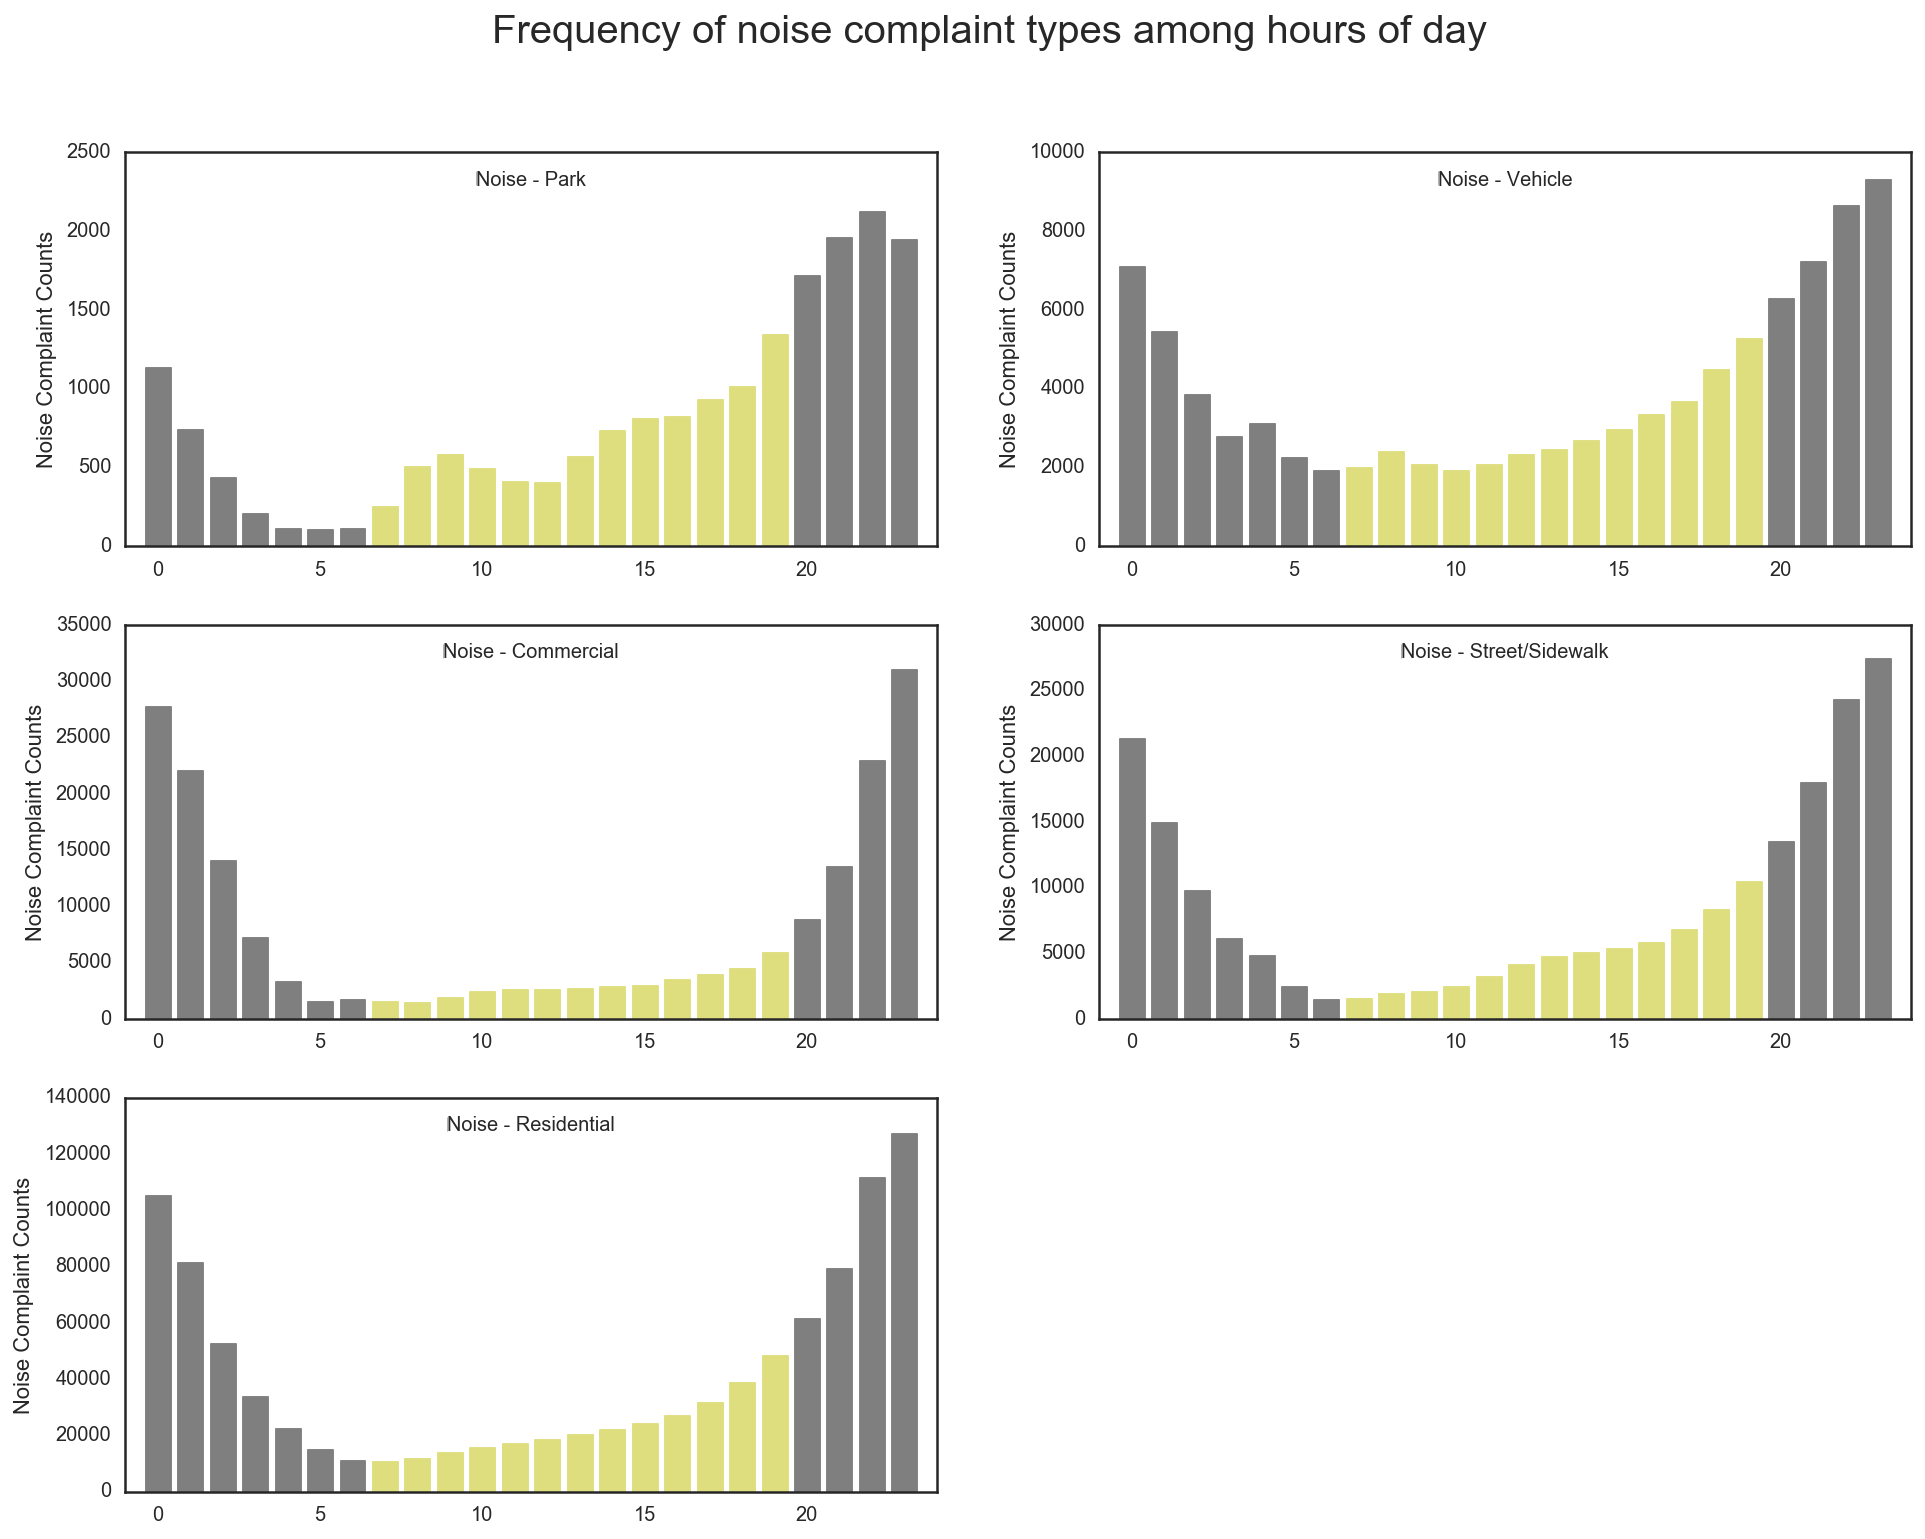

In [19]:
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize = (16,12))
plt.suptitle('Frequency of noise complaint types among hours of day',fontsize=20)
for index, complain in enumerate(noise_list):
    # Create a matrix of subplots with 3 rows and two columns
    plt.subplot(3, 2, index + 1)
     
    # Create a sub-df for each category
    temp_df = df_noise[df_noise['Complaint Type'] == complain]
    
    # Drop 2017 and 2010 as it could be misleading as only few values for the first two
    # months exist
    temp_df = temp_df[(temp_df['Created Year'] != 2017) & (temp_df['Created Year'] != 2010)]
    
    # Count frequency of complaint occurence
    occurence = temp_df.groupby('Created Hour')['Created Hour'].count().reset_index(name='count').sort_values(by='Created Hour', ascending=1)
    
    # Assign x and y values
    x = occurence['Created Hour']
    y = occurence['count']

    # Give indeces to complaints
    x_pos = np.arange(len(x))
    
    bars = plt.bar(x_pos,y,align='center',alpha=.5, color='grey',label=complain)
    # Distinguise day hours with different color 
    for i,bar in enumerate(bars):
        if (i>=0 and i<7) or i>=20:
            bar.set_color('k')
        else:
            bar.set_color('y')
        
    plt.xticks(np.arange(0,24,5))
    plt.ylabel("Noise Complaint Counts")
    plt.legend(loc='upper center',frameon=False,handlelength=0, handletextpad=0)
    plt.xlim(-1,24)
    
# Show the barplot
plt.show()

It is obviously seen that all noise complaint types have the same pattern. Less complaints in day hours (yellow bars) and more in night hours (gray bars).

## The types of noise complaints and how they take place across NYC

So now we'll be combining information about City and Complaint Type to explore differences between NYC's neighborhoods. First, simply list the names of NYC's **districts**.

In [11]:
# Create a list of unique values of districts excluding nulls
districts = [i for i in df_noise['City'].unique() if pd.notnull(i)]
print 'The %d districts of NYC are: \n%s' % (len(districts), districts)

The 48 districts of NYC are: 
['EAST ELMHURST', 'NEW YORK', 'FRESH MEADOWS', 'ELMHURST', 'BROOKLYN', 'BRONX', 'FLUSHING', 'SAINT ALBANS', 'FOREST HILLS', 'WOODSIDE', 'OZONE PARK', 'CORONA', 'MASPETH', 'SUNNYSIDE', 'STATEN ISLAND', 'ASTORIA', 'LONG ISLAND CITY', 'JAMAICA', 'REGO PARK', 'RICHMOND HILL', 'OAKLAND GARDENS', 'HOLLIS', 'BAYSIDE', 'KEW GARDENS', 'JACKSON HEIGHTS', 'SOUTH RICHMOND HILL', 'FAR ROCKAWAY', 'RIDGEWOOD', 'QUEENS VILLAGE', 'SOUTH OZONE PARK', 'ROSEDALE', 'HOWARD BEACH', 'COLLEGE POINT', 'WOODHAVEN', 'CAMBRIA HEIGHTS', 'SPRINGFIELD GARDENS', 'WHITESTONE', 'LITTLE NECK', 'ROCKAWAY PARK', 'BELLEROSE', 'ARVERNE', 'MIDDLE VILLAGE', 'GLEN OAKS', 'QUEENS', 'FLORAL PARK', 'NEW HYDE PARK', 'BREEZY POINT', 'CENTRAL PARK']


We will explore which districts have the **most noise complaints**.

In [12]:
# Keep only the Category and the District column
df_noise_district = df_noise.filter(items=['Complaint Type', 'City'])
df_noise_district = df_noise_district[df_noise_district['City'].isin(districts)]

# List the number of crimes per District
complaint_freq_dist = df_noise_district.groupby('City')['City'].count(
).reset_index(name='count').sort_values(by='count', ascending=0)

# Print the district with the most crimes
print 'The districts with the most noise complains are:\n'
complaint_freq_dist = complaint_freq_dist.reset_index().drop('index',
                                                                         axis=1)
complaint_freq_dist[:5]

The districts with the most noise complains are:



City   count
0       BROOKLYN  539582
1       NEW YORK  516474
2          BRONX  375829
3  STATEN ISLAND   46552
4        JAMAICA   32725

Keep the **most noisy districts** in a seperate list.

In [26]:
noisy_districts = [i for i in complaint_freq_dist['City'][:10]]

Next, we want to generate a slightly more complicated graphic. We are interested to know if there are certain complaints that happen much more in certain neighborhoods than what's typical.    
First, we need to calculate the relative probabilities of seeing each type of noise complaint in the dataset as a whole. We will call it **P(complaint)**

In [19]:
# Create one more column with the relative probability of seeing each type of noise complaint
noise_freq['P(complaint)'] = noise_freq['count']/noise_freq['count'].sum()
noise_freq

Complaint Type    count  P(complaint)
0    Collection Truck Noise      274      0.000151
1        Noise - Helicopter     3772      0.002072
2  Noise - House of Worship     7443      0.004089
3              Noise Survey    16022      0.008802
4              Noise - Park    22205      0.012199
5           Noise - Vehicle   115853      0.063649
6        Noise - Commercial   229477      0.126073
7   Noise - Street/Sidewalk   236406      0.129880
8       Noise - Residential  1188740      0.653085

In [15]:
# Create one more column with the relative probability of seeing each type of complaint
complaint_freq_dist['P(district)'] = complaint_freq_dist['count']/complaint_freq_dist['count'].sum()
complaint_freq_dist[:5]

City   count  P(district)
0       BROOKLYN  539582     0.300992
1       NEW YORK  516474     0.288101
2          BRONX  375829     0.209646
3  STATEN ISLAND   46552     0.025968
4        JAMAICA   32725     0.018255

Next, we calculate that same probability distribution but for each NYC district, let's call that **P(complaint|district)**.

In [20]:
# Keep only the Noise complaint types and the Districts in a seperate dataframe
df_noise_2 = df_noise.filter(items=['Complaint Type', 'City'])

# List the number of complaints per District per Category
complaint_freq_mix = df_noise_2.groupby(
    ['Complaint Type', 'City']).size().reset_index(name='count')

# Create two more columns with the count per district(count_x) and the
# probability(P(complaint|district))
complaint_freq_mix = pd.merge(complaint_freq_mix.groupby('City')['count'].sum().reset_index(),
                                complaint_freq_mix,
                                on='City',
                                how='outer')
complaint_freq_mix['P(complaint|district)'] = complaint_freq_mix['count_y'] / complaint_freq_mix['count_x']
complaint_freq_mix[:5]

City  count_x           Complaint Type  count_y  P(complaint|district)
0  ARVERNE     2394       Noise - Commercial        9               0.003759
1  ARVERNE     2394             Noise - Park       16               0.006683
2  ARVERNE     2394      Noise - Residential     2149               0.897661
3  ARVERNE     2394  Noise - Street/Sidewalk      142               0.059315
4  ARVERNE     2394          Noise - Vehicle       78               0.032581

Now we look at the ratio **P(complaint|district)/P(complaint)**. That ratio is equal to 1 if the noise comlpaint occurs at the same level within a district as in the city as a whole. If it's greater than one, it means that the complaint occurs more frequently within that district. If it's smaller than one, it means that the complaint is rarer within the district in question than in the city as a whole.

In [23]:
# Merge the two tables created above to do the calculation
df_noise_final = pd.merge(complaint_freq_mix, noise_freq,
                    on='Complaint Type', how='outer')
df_noise_final = df_noise_final.drop(['count_x', 'count_y', 'count'], axis=1)  # auto-created

# Create a new column with the Ratio
df_noise_final['Ratio'] = df_noise_final['P(complaint|district)'] / df_noise_final['P(complaint)']

# Sort by District
df_noise_final = df_noise_final.sort_values(by='City').reset_index().drop('index', axis=1)
df_noise_final.head(10)

City           Complaint Type  P(complaint|district)  P(complaint)  \
0  ARVERNE       Noise - Commercial               0.003759      0.126073   
1  ARVERNE      Noise - Residential               0.897661      0.653085   
2  ARVERNE          Noise - Vehicle               0.032581      0.063649   
3  ARVERNE             Noise - Park               0.006683      0.012199   
4  ARVERNE  Noise - Street/Sidewalk               0.059315      0.129880   
5  ASTORIA  Noise - Street/Sidewalk               0.089676      0.129880   
6  ASTORIA      Noise - Residential               0.554103      0.653085   
7  ASTORIA          Noise - Vehicle               0.051296      0.063649   
8  ASTORIA       Noise - Commercial               0.294524      0.126073   
9  ASTORIA             Noise - Park               0.010400      0.012199   

      Ratio  
0  0.029819  
1  1.374493  
2  0.511894  
3  0.547851  
4  0.456691  
5  0.690457  
6  0.848440  
7  0.805926  
8  2.336137  
9  0.852541

For the most noisy districts **plot these ratios** for the 5 noise complaints.

In [28]:
# Filter out all those lines not included in the 10 noisy districts
df_noise_final_focus = df_noise_final[df_noise_final['City'].isin(noisy_districts)]
df_noise_final_focus.head(5)

City           Complaint Type  P(complaint|district)  P(complaint)  \
5  ASTORIA  Noise - Street/Sidewalk               0.089676      0.129880   
6  ASTORIA      Noise - Residential               0.554103      0.653085   
7  ASTORIA          Noise - Vehicle               0.051296      0.063649   
8  ASTORIA       Noise - Commercial               0.294524      0.126073   
9  ASTORIA             Noise - Park               0.010400      0.012199   

      Ratio  
5  0.690457  
6  0.848440  
7  0.805926  
8  2.336137  
9  0.852541

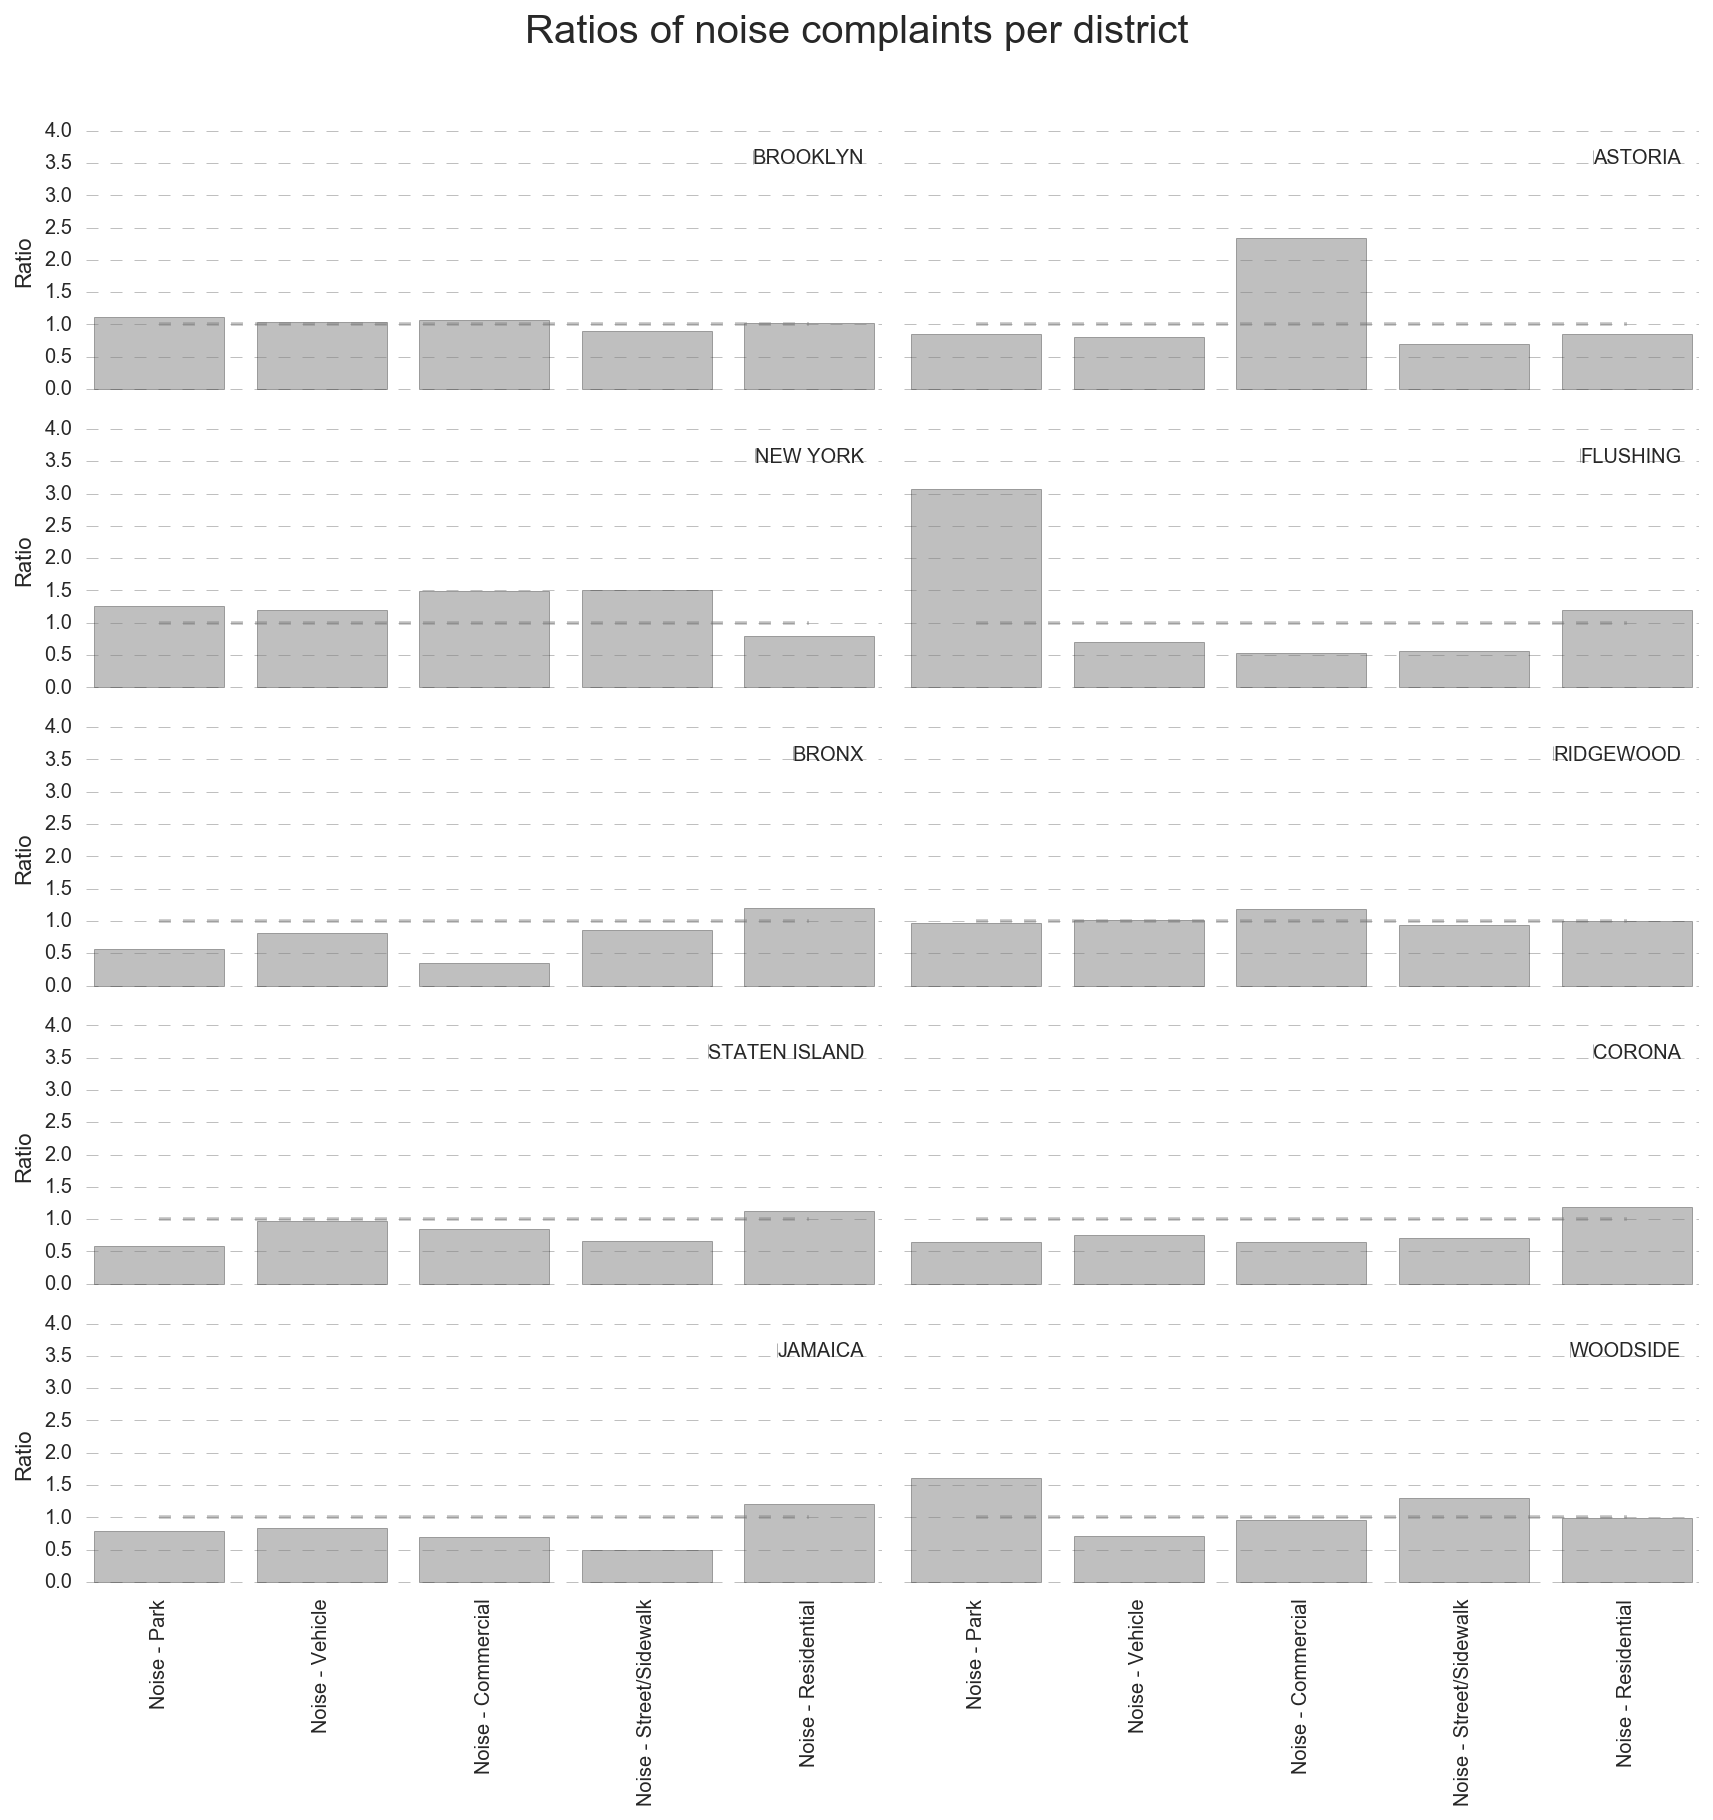

In [37]:
%config InlineBackend.figure_format = 'retina'

# use seaborn to set our graphing style. The style 'white' creates a white background for our graph
sns.set_style("white") 

# Assign variables to axes and figure
fig, ax = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(12, 12))

# Assign the size and the Super title
fig.suptitle('Ratios of noise complaints per district', fontsize=20, y=1.05)

for index,district in enumerate(noisy_districts):
    # Create a sub-df for each category
    temp_df = df_noise_final_focus[df_noise_final_focus['City']==district]
    
    # Drop columns to minimize the memory usage(optional)
    temp_df = temp_df.drop(['City','P(complaint)','P(complaint|district)'], axis=1) # axis=1 means column
    
    # Assign x
    x = list(noise_list)
    # Give indeces to complaint
    x_pos = np.arange(len(x))
    
    # Assign y and keep the same sorting for each plot
    mapping = {complaint:i for i,complaint in enumerate(x)}
    key = temp_df['Complaint Type'].map(mapping)
    temp_df = temp_df.iloc[key.argsort()]
    y = temp_df['Ratio']
    
    # Assign x and y to subplots                   
    subindex = 0
    # Index < 5 means left column else right column
    if index < 5:
        final_index = index
        final_subindex = subindex
    else:
        final_index = index - 5
        final_subindex = subindex + 1
    
    # Create an ax object
    ax_temp =  ax[final_index][final_subindex]
    
    # Create a series of grey dashed lines across the each
    # labled y-value of the graph
    ax_temp.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)  
    # Feed the ax object with the x and y values
    ax_temp.bar(x_pos,y,align='center',alpha=.5, color='grey',label=district)
    ax_temp.legend(loc='upper right',frameon=False,handlelength=0, handletextpad=0)
    ax_temp.margins(0.01)
    # Draw a threshold line
    ax_temp.plot(x_pos, [1 for _ in range(len(x_pos))], linestyle='--', color = 'grey', alpha = .5)
    # i for i in range(len(x_pos) + 1)
    # 
    
    # get rid of borders for our graph using seaborn's despine function
    sns.despine(top=1, right=1, left=1, bottom=1)
    
    # Set the rotation to vertical
    for tick in ax_temp.get_xticklabels():
        tick.set_rotation(90)
    # Set Ratio label only in the left column
    if index < 5:
        ax_temp.set_ylabel("Ratio")
            
    # Set xticks and yticks parameters
    plt.setp(ax, xticks=x_pos, xticklabels=x,yticks=np.arange(0,4.5,0.5)) 
# Show the barplot
fig.tight_layout()
plt.show()

As seen on the above boxplots there are some bars that reach above the **threshold (Ratio = 1)** and some that are way below it. For example in **ASTORIA** district there is a high ratio of **Commercial Noise** which means that in comparison to the rest of the noise complaints, commercial is the one with the highest impact in ASTORIA.

## Predict the destrict of noise complaints using Decision Tree Classifier

In [39]:
# Focus only on the 10 noisy districts
df_noise_focus = df_noise[df_noise['City'].isin(noisy_districts)]

In [40]:
# Encode categorical variables to digits
le = LabelEncoder()
X = le.fit_transform(df_noise_focus['Complaint Type'])  
Y = le.fit_transform(df_noise_focus['City'])

In [41]:
# Split training and testing data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [42]:
#Train the decision tree classifier
clf = tree.DecisionTreeClassifier()
#The scikit-learn fit function needs a list of lists as input even if the nested lists have length 1
clf = clf.fit(X_train[:,None], Y_train[:,None])
# Predict the testing features
pred = clf.predict(X_test[:,None])

We re-convert the numerical values of Y_test and pred to categorical, since we'll need them for the next step.


In [43]:
pred = le.inverse_transform(pred)
Y_test_inv = le.inverse_transform(Y_test)

We calculate the fraction of correct predictions.

In [44]:
print 'Fraction of correct predictions : %.2f%%' % (clf.score(X_test[:,None],Y_test[:,None])*100)

Fraction of correct predictions : 37.96%


Which means that our classifier is not that reliable to predict the correct district if we only fit it with the noise type. But **if we restrict the training/prediction to single districts** (for example, predicting BRONX vs. all other districts) we will see a different score for the classifier.

In [47]:
del df_binary_districts

In [50]:
# Remove pandas loc warning
pd.options.mode.chained_assignment = None

#Function to get the binary representation of a specific value
def get_binary_repr(value,district):
    if value==district:
        return district
    return 'NOT'+district

# Initiate PrettyTable
x = PrettyTable(field_names=['District','Correct Prediction'])
for district in noisy_districts:
    df_binary_districts = df_noise_focus
    df_binary_districts['District_Bin'] = df_binary_districts['City'].apply(lambda x: get_binary_repr(x,district))

    # Split training and testing data (N.B. X is the same as before)
    Y_new = df_binary_districts['District_Bin']
    Y_new = le.fit_transform(Y_new)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y_new, test_size=0.1, random_state=0)
    
    #Train classifier and predict
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train[:,None], Y_train[:,None])

    #Calculate fraction of correct predictions
    x.add_row([district,str(clf.score(X_test[:,None],Y_test[:,None])*100)[:5]+'%'])
    
print x

+---------------+--------------------+
|    District   | Correct Prediction |
+---------------+--------------------+
|    BROOKLYN   |       66.39%       |
|    NEW YORK   |       67.80%       |
|     BRONX     |       76.75%       |
| STATEN ISLAND |       97.09%       |
|    JAMAICA    |       97.95%       |
|    ASTORIA    |       97.96%       |
|    FLUSHING   |       98.82%       |
|   RIDGEWOOD   |       99.02%       |
|     CORONA    |       99.00%       |
|    WOODSIDE   |       99.16%       |
+---------------+--------------------+


This is a pretty cool picture. We can easily predict and rely in our prediction that a specific noise complaint will occur in a specific borough. But let's **plot on a map** all noise complaints in different color.

### Plot noise complains on map (only noisy districts)

Firstly, we should check for outliers in the coordinates dataset.

In [53]:
#Checking if the data is clean enough (no outliers)
lats = [float(el) for el in list(df_noise_focus['Latitude'])]
longs = [float(el) for el in list(df_noise_focus['Longitude'])]
print 'Latitudes:',set([round(el) for el in lats])
print 'Longitudes:',set([round(el) for el in longs])

Latitudes: set([40.0, 41.0])
Longitudes: set([-74.0])


Longs and Lats seem normal with no outliers. Now we are ready to plot each complain as a point on a map. But before that, we should **create a dictionary**(mandatory for the **geoplotlib library**) with two keys(lat and lon) and two lists as values of each key(lists of coordinates).

In [54]:
# Create dictionary and put each complaint's coordinates as a seperate key,value pair
geo_dict = {}
for complaint in noise_list:
    geo_data_for_plotting = {"lat": [float(el) for el in list(df_noise_focus[df_noise_focus['Complaint Type']==complaint]['Latitude'])],
                             "lon": [float(el) for el in list(df_noise_focus[df_noise_focus['Complaint Type']==complaint]['Longitude'])]}
    geo_dict[complaint] = geo_data_for_plotting

And now we are fully ready for plotting the complains with different color per noise complain type on a map.

In [58]:
#Let's define a function for plotting the dot map, as it will be used later
def dot_plot(geo_dict,size):
    colors = ['white', 'black', 'red', 'green', 'blue']

    for i,complaint in enumerate(noise_list):
        # Create a legend
        print '%s\t\t ----->\t\t%d observations\t ----->\t%s' % (colors[i],len(geo_dict[complaint]['lon']),complaint)
        # Fit the map with dots
        geoplotlib.dot(geo_dict[complaint], color=colors[i], point_size=size)

    # Create an BoundigBox for the limits of the map
    bbox = BoundingBox(north=max(geo_dict[complaint]['lat']),
                       west=min(geo_dict[complaint]['lon']),
                       south=min(geo_dict[complaint]['lat']),
                       east=max(geo_dict[complaint]['lon']))
    geoplotlib.set_bbox(bbox)
    geoplotlib.inline()
    
dot_plot(geo_dict,.6)

white		 ----->		20207 observations	 ----->	Noise - Park
black		 ----->		104072 observations	 ----->	Noise - Vehicle
red		 ----->		211209 observations	 ----->	Noise - Commercial
green		 ----->		223077 observations	 ----->	Noise - Street/Sidewalk
blue		 ----->		1049647 observations	 ----->	Noise - Residential


### Predict the district of noise complaints using KNN classifier

According to the above, the classifier will more likely fit those dots with high density(blue - Residential Noise) together with those dots with lower density(black - Noise Park). Below we get a **balanced dataset** by taking an equal number of random samples for each category:

In [59]:
num_samples = 2000 #Number of random samples to extract

# Randomly extract a balanced number of samples
df_noise_bal = pd.DataFrame(columns = ['Complaint Type','Longitude','Latitude'])
for complaint in noise_list:
    sample = df_noise_focus[df_noise_focus['Complaint Type']==complaint].sample(n=num_samples).filter(items=['Complaint Type','Longitude','Latitude'])
    df_noise_bal = pd.concat([sample,df_noise_bal])

After creating the **balanced dataset** is should sum up to 10000 lines(2000 lines for each of the 5 noise type complaints). Let's be sure that the sampling worked correctly. 

In [60]:
len(df_noise_bal)

10000

Let's plot the **balanced map** and check the distribution of points before fitting the classifier. Firstly we should create a new balanced dictionary for the **geoplotlib** library.

In [61]:
# Create a dictionary and put each crime's coordinates as a seperate key,value pair
geo_dict_bal = {}
for complaint in noise_list:
    geo_data_for_plotting = {"lat": [float(el) for el in list(df_noise_bal[df_noise_bal['Complaint Type']==complaint]['Latitude'])],
                             "lon": [float(el) for el in list(df_noise_bal[df_noise_bal['Complaint Type']==complaint]['Longitude'])]}
    geo_dict_bal[complaint] = geo_data_for_plotting

In [63]:
dot_plot(geo_dict_bal,1)

white		 ----->		2000 observations	 ----->	Noise - Park
black		 ----->		2000 observations	 ----->	Noise - Vehicle
red		 ----->		2000 observations	 ----->	Noise - Commercial
green		 ----->		2000 observations	 ----->	Noise - Street/Sidewalk
blue		 ----->		2000 observations	 ----->	Noise - Residential


Now we are ready to fit the classifier with the balanced dataset. But in order to distinguise the clusters that will be created from the classifiers we should first create an approximately **square grid** of point that runs over NYC. The size grid will be **100x100**(10000 points in total). 

In [79]:
def grid_creator(df_data,grid_size):
    '''Create a grid of XxY'''
    # Define grid size
    grid_size = grid_size

    #Generating all the coordinates of the points contained in the grid
    min_lat = float(min(df_data['Latitude']))
    max_lat = float(max(df_data['Latitude']))
    min_lon = float(min(df_data['Longitude']))
    max_lon = float(max(df_data['Longitude']))
    all_lats = np.arange(min_lat,max_lat,(max_lat-min_lat)/grid_size)
    all_longs = np.arange(min_lon,max_lon,(max_lon-min_lon)/grid_size)

    #List of tuples representing points, generated combining all possible values of latitudes/longitudes
    all_points = set() #Created as set, to be sure it won't contain duplicates
    for lat in all_lats:
        for lon in all_longs:
            all_points.add((lat,lon)) #each coordinate saved as a tuple
    all_points = list(all_points)

    all_grid_points = {'lat': [el[0] for el in all_points],
                       'lon':[el[1] for el in all_points]}
    return all_grid_points,all_points

In [81]:
all_grid_points,all_points = grid_creator(df_noise_focus,100)

Below we plotted just an overview of what does the grid look like (before the classification, only raw coordinate points, to make sure it was as expected):

In [82]:
geoplotlib.dot(all_grid_points, color='black', point_size=2)

# Create an BoundigBox for the limits of the map
bbox = BoundingBox(north=max(all_grid_points['lat'])-0.1,
                   west=min(all_grid_points['lon'])+0.1,
                   south=min(all_grid_points['lat'])+0.1,
                   east=max(all_grid_points['lon'])-0.1)
geoplotlib.set_bbox(bbox)
geoplotlib.inline()

As it's shown below, we used Object Oriented Programming for Python to create a Layer class, whose concern is to display the title on each plot and plot complex data. We fit the **KNN classifier** inside the invalidate() method and according to the output provided by the prediction we draw each point of the grid with the correct color.
For each number of neighbors we plot the colored grid, in order to see what does this parameter affect concerning the model.

In [83]:
class KNeighbors_Layer(BaseLayer):

    def __init__(self, data,k,all_grid_points):
        self.data = data #Is the balanced dataframe
        self.k = k # number of neighbors
        self.all_grid_points = all_grid_points #All the coordinate of the grid points

    def invalidate(self, proj):
        self.painter = BatchPainter() # initilizes the painter
        
        # Train the KNN classifier
        features = np.array(self.data[['Latitude','Longitude']]) # Notice that X,Y are reverted by default in the original data frame
        labels = np.array(self.data['Complaint Type'])
        clf = KNeighborsClassifier(n_neighbors=self.k)
        clf.fit(features, labels)
        print 'Neighbors # %d \t\t ----->\t\t %.2f%% ' % (self.k,(clf.score(features, labels)*100))
        
        #Prepare the grid points to predict, building matrix
        x, y = proj.lonlat_to_screen(self.all_grid_points['lon'], self.all_grid_points['lat'])
        #Used column stack to concatenate by columns the two arrays and create a 2D array
        grid_points_matrix = np.column_stack((self.all_grid_points['lat'],self.all_grid_points['lon']))
        Z = clf.predict(grid_points_matrix)
        
        # Create colormap per complaint type
        self.cmap = {'Noise - Park':'white','Noise - Vehicle':'black','Noise - Street/Sidewalk':'red', 
                    'Noise - Commercial': 'green', 'Noise - Residential':'blue'}
        for complaint in noise_list:
            self.painter.set_color(self.cmap[complaint])
            self.painter.points(x[Z == complaint], y[Z == complaint], 4) # paints the points according to predicted crimes
    
    # Map interaction
    def draw(self, proj, mouse_x, mouse_y, ui_manager):
        ui_manager.info('Number of neighbors : %d' % self.k)
        self.painter.batch_draw()

After the definition of the class, we finally plot the different dot maps, each one using a different number of neighbors for the classifier.

In [85]:
num_neighbors=[3,5,10,30]
colors = ['white', 'black', 'red', 'green', 'blue']

# Create Legend
print '********************************\n************ Legend ************\n********************************\n' 
for i,complaint in enumerate(noise_list):
    print '%s\t\t ----->\t\t%s community' % (colors[i],complaint)
print '---------------------------------------------------------------------\n\n'
print '*******************************************\n************ Prediction Scores ************\n*******************************************\n'

for k in num_neighbors:
    geoplotlib.add_layer(KNeighbors_Layer(df_noise_bal,k,pd.DataFrame(all_grid_points)))
    geoplotlib.set_smoothing(True)
    bbox = BoundingBox(north=max(all_grid_points['lat'])-0.1,
                   west=min(all_grid_points['lon'])+0.1,
                   south=min(all_grid_points['lat'])+0.1,
                   east=max(all_grid_points['lon'])-0.1)
    geoplotlib.set_bbox(bbox)
    geoplotlib.inline()

********************************
************ Legend ************
********************************

white		 ----->		Noise - Park community
black		 ----->		Noise - Vehicle community
red		 ----->		Noise - Commercial community
green		 ----->		Noise - Street/Sidewalk community
blue		 ----->		Noise - Residential community
---------------------------------------------------------------------


*******************************************
************ Prediction Scores ************
*******************************************

Neighbors # 3 		 ----->		 68.62% 


Neighbors # 5 		 ----->		 61.60% 


Neighbors # 10 		 ----->		 53.22% 


Neighbors # 30 		 ----->		 44.32% 


## D3 Visualizations

* Create a hidden transparent grid on a map and each time a user press anywhere on map(on click), there will be a tooltip displaying one of the five noise classification types that the KNN classifier suggests.  

In [106]:
# Create a dataframe to fit the data
temp_df = pd.DataFrame(all_grid_points)

In [107]:
# Create a function that adds a column to a grid after applying KNN (k and dataframe as parameter)
def KNN_helper(df_data, k, all_grid_points):
    # Train the KNN classifier
    features = np.array(df_data[['Latitude','Longitude']]) # Notice that X,Y are reverted by default in the original data frame
    labels = np.array(df_data['Complaint Type'])
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(features, labels)
    
    #Used column stack to concatenate by columns the two arrays and create a 2D array
    grid_points_matrix = np.column_stack((all_grid_points['lat'],all_grid_points['lon']))
    Z = clf.predict(grid_points_matrix)
    if str(k)+'_neighs' not in temp_df.columns:
        temp_df[str(k)+'_neighs'] = Z        
    print 'For K = %d the update is done!'%k

In [109]:
num_neighbors=[5,10,30]

for k in num_neighbors:
    KNN_helper(df_noise_bal,k,pd.DataFrame(all_grid_points))

For K = 5 the update is done!
For K = 10 the update is done!
For K = 30 the update is done!


In [110]:
# Check df
temp_df.head()

lat        lon            5_neighs            10_neighs  \
0  40.705844 -73.762508     Noise - Vehicle  Noise - Residential   
1  40.507101 -73.881885  Noise - Commercial   Noise - Commercial   
2  40.772092 -74.185301     Noise - Vehicle  Noise - Residential   
3  40.614753 -73.762508     Noise - Vehicle  Noise - Residential   
4  40.784514 -74.041054        Noise - Park         Noise - Park   

             30_neighs  
0      Noise - Vehicle  
1   Noise - Commercial  
2  Noise - Residential  
3         Noise - Park  
4   Noise - Commercial

In [112]:
# Save it to a csv for D3
temp_df.to_csv('../data/KNN_map.csv', index=False)